# This is the **TEMPORAL MODEL**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from scipy import sparse
from sys import getsizeof
import cv2
import numpy as np
import os
import datetime as dt
import json
import sys
import matplotlib.pyplot as plt
import random
import seaborn as sns

data = {}
processed = {}
coords = {
    "limits_4326": {
        "xmin":-80.4,
        "xmax": -60.6,
        "ymin": 44.6,
        "ymax": 52.6
    }
}

target_limit =  "limits_4326" #"limits_testing_9_chunks"
xmin, xmax, ymin, ymax = (coords[target_limit]["xmin"]), (coords[target_limit]["xmax"]), (coords[target_limit]["ymin"]), (coords[target_limit]["ymax"])

chunksDirectory = "drive/MyDrive/Wildfire Research Project/Wildfires Data/Chunks"

In [ ]:
DataOrder = {
    4011: "Thunder", # 0 to 4010
    13433: "Human", # 4011 to 13432
    28433: "No-Fire", # 13433 to 28432
    43433: "No-Fire-Data" # 28433 to 43432
}

DataIntervals = {
    "Thunder": (0, 4010),
    "Human": (4011, 13432),
    "No-Fire": (13433, 28432),
    "No-Fire-Data": (28433, 43432)
}

DataTypeToOutput = {
    "Thunder": 1,
    "Human": 1,
    "No-Fire": 0,
    "No-Fire-Data": 0
}

firesCount = 11196
noFiresCount = 13350

In [ ]:
variableIndices = [
    0,
    36, # Precipitation
    72, # Temp Max
    108, # Temp Min
    229, # EVI
    350, # NDVI
    471, # Lai
    615, # Hydrography
    759, # Roads
    903 # Lines
]

parameters = [
    "Precipitation (1D)",
    "Temp Max (1D)",
    "Temp Min (1D)",
    "EVI (16D)",
    "NDVI (16D)",
    "LAI (16D)",
    "Hydrography",
    "Roads",
    "Transmission Lines"
]

## Imports and Utils

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
import math
import pickle

basePath = "drive/MyDrive/Wildfire Research Project/Models/Temporal/"

In [ ]:
trainX = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainX.npy")
trainY = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainY.npy").ravel()

In [ ]:
np.count_nonzero(trainY), trainY.shape[0] - np.count_nonzero(trainY)

(13350, 11196)

In [ ]:
trainX = np.nan_to_num(trainX) # Replace nan with 0

In [ ]:
def generateDataSplits(fire, noFire):
  trainX = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainX.npy")
  trainY = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainY.npy").ravel()

  trainX, trainY = shuffle(trainX, trainY, random_state=0)

  trainX = np.nan_to_num(trainX) # Replace nan with 0

  tempTrainX = []
  tempTrainY = []
  tempFireCount = 0
  tempNoFireCount = 0
  for i in range(24546):
    if trainY[i] == 1:
      tempFireCount+=1
      if (tempFireCount > fire):
        continue
    else:
      tempNoFireCount+=1
      if (tempNoFireCount > noFire):
        continue

    tempTrainX.append(trainX[i])
    tempTrainY.append(trainY[i])

  trainX = np.array(tempTrainX)
  trainY = np.array(tempTrainY)

  # Shuffle Again After
  trainX, trainY = shuffle(trainX, trainY, random_state=2)
  return shuffle(trainX, trainY, random_state=2)

In [ ]:
def mixVariable(variableIdx, testX, testY): # 1-indexed
  shuffleStart = variableIndices[variableIdx-1]
  shuffleEnd = variableIndices[variableIdx]
  testXCopy = np.copy(testX)
  print(testX.shape[0])

  for i in range(testX.shape[0]):
    randomIdx = random.randint(0, testX.shape[0]-1)
    while (randomIdx == i):
      randomIdx = random.randint(0, testX.shape[0]-1)

    for idx in range(shuffleStart, shuffleEnd):
      testXCopy[i, idx] = testX[randomIdx, idx]

  return testXCopy, testY

### Base Model

In [ ]:
logreg_base = LogisticRegression(max_iter=1000)

In [ ]:
rfreg_base = RandomForestClassifier(min_samples_split=10)

In [ ]:
gbreg_base = GradientBoostingClassifier(min_samples_split=10)

#### Testing Splits:

In [ ]:
splitPath = basePath + "Splits/"

In [ ]:
testingSplits = [
    [50, 50], [5, 95], [20, 80], [30, 70], [40, 60]
]

In [ ]:
for split in testingSplits:
  print("---------------------------")
  print(split)
  print("---------------------------")
  total = firesCount*2
  fireCount = int((split[0]/100)*total)
  noFireCount = total-fireCount

  if (noFireCount > noFiresCount):
    noFireCount = noFiresCount
    fireCount = int(noFireCount/(split[1]/100))-noFireCount

  print(fireCount, noFireCount)
  trainX, trainY = generateDataSplits(fireCount, noFireCount)

  X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.1, random_state=0)
  print(np.count_nonzero(y_test), "in test length of", len(y_test), "-", np.count_nonzero(y_test)/len(y_test))

  print("Log Reg")
  logreg_base.fit(X_train, y_train.ravel())
  print(logreg_base.score(X_test, y_test))
  print(confusion_matrix(y_test, logreg_base.predict(X_test)))
  ConfusionMatrixDisplay.from_predictions(
      y_true = y_test, y_pred = logreg_base.predict(X_test), normalize="true",
      display_labels=logreg_base.classes_,
      colorbar=False, cmap="Blues", values_format=".3g"
    ).plot()
  plt.title(f"Logistic Regression {split[0]}-{split[1]}")
  plt.show()

  print("Random Forest")
  rfreg_base.fit(X_train, y_train)
  print(rfreg_base.score(X_test, y_test))
  print(confusion_matrix(y_test, rfreg_base.predict(X_test)))
  ConfusionMatrixDisplay.from_predictions(
      y_true = y_test, y_pred = rfreg_base.predict(X_test), normalize="true",
      display_labels=rfreg_base.classes_,
      colorbar=False, cmap="Purples", values_format=".3g"
    ).plot()
  plt.title(f"Random Forest Classifier {split[0]}-{split[1]}")
  plt.show()

  print("Gradient Boost")
  gbreg_base.fit(X_train, y_train)
  print(gbreg_base.score(X_test, y_test))
  print(confusion_matrix(y_test, gbreg_base.predict(X_test)))
  ConfusionMatrixDisplay.from_predictions(
      y_true = y_test, y_pred = gbreg_base.predict(X_test), normalize="true",
      display_labels=gbreg_base.classes_,
      colorbar=False, cmap="Reds", values_format=".3g"
    ).plot()
  plt.title(f"Gradient Boost Classifier {split[0]}-{split[1]}")
  plt.show()

  with open(splitPath+f"logreg_{split[0]}_{split[1]}.pkl", 'wb') as f:
    pickle.dump(logreg_base, f)
  with open(splitPath+f"randomf_{split[0]}_{split[1]}.pkl", 'wb') as f:
    pickle.dump(rfreg_base, f)
  with open(splitPath+f"gradient_{split[0]}_{split[1]}.pkl", 'wb') as f:
    pickle.dump(gbreg_base, f)

#### K-fold Cross Validation with Best Split

In [ ]:
X_train_total, Y_train_total = generateDataSplits(11196 , 11196)
trainX, X_test, trainY, y_test = train_test_split(X_train_total, Y_train_total, test_size=0.1, random_state=0)

In [ ]:
split = "50:50"


In [ ]:
def train_logreg_base(savePath):
  print("logreg")
  accuracies_lg = []
  models_lg = []

  for i in range(10):
    print(i)
    intervalStart, intervalEnd = int(i*(trainX.shape[0]/10)), int((i+1)*(trainX.shape[0]/10))
    # test_x, test_y = trainX[intervalStart:intervalEnd], trainY[intervalStart:intervalEnd]
    train_x, train_y = np.concatenate((trainX[:intervalStart], trainX[intervalEnd:])), np.concatenate((trainY[:intervalStart], trainY[intervalEnd:])).ravel()
    logreg_base.fit(train_x, train_y)
    accuracies_lg.append(logreg_base.score(X_test, y_test))
    models_lg.append(logreg_base)
    print(accuracies_lg[i])

    # Display
    print(confusion_matrix(y_test, logreg_base.predict(X_test)))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, logreg_base.predict(X_test)), display_labels=logreg_base.classes_).plot()
    plt.title(f"Logistic Regression {i}")
    plt.show()

  with open(basePath+split+"/logistic_base.pkl", 'wb') as f:
    pickle.dump(models_lg, f)
  np.save(basePath+split+"/logistic_base_acc", accuracies_lg)

  print(accuracies_lg)


In [ ]:
def train_rf_base(split):
  accuracies_rf = []
  models_rf = []
  print("random forest")

  for i in range(10):
    print(i)
    intervalStart, intervalEnd = int(i*(trainX.shape[0]/10)), int((i+1)*(trainX.shape[0]/10))
    # test_x, test_y = trainX[intervalStart:intervalEnd], trainY[intervalStart:intervalEnd]
    train_x, train_y = np.concatenate((trainX[:intervalStart], trainX[intervalEnd:])), np.concatenate((trainY[:intervalStart], trainY[intervalEnd:])).ravel()
    rfreg_base.fit(train_x, train_y)
    accuracies_rf.append(rfreg_base.score(X_test, y_test))
    models_rf.append(rfreg_base)
    print(accuracies_rf[i])

    # Display
    print(confusion_matrix(y_test, rfreg_base.predict(X_test)))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, rfreg_base.predict(X_test)), display_labels=rfreg_base.classes_).plot()
    plt.title(f"Random Forest Classifier {split[0]}-{split[1]}")
    plt.show()

  with open(basePath+split+"/random_forest_base.pkl", 'wb') as f:
    pickle.dump(models_rf, f)
  np.save(basePath+split+"/random_forest_acc", accuracies_rf)

In [ ]:
def train_gb_base(split):
  accuracies_gb = []
  models_gb = []

  for i in range(10):
    print(i)
    intervalStart, intervalEnd = int(i*(trainX.shape[0]/10)), int((i+1)*(trainX.shape[0]/10))
    # test_x, test_y = trainX[intervalStart:intervalEnd], trainY[intervalStart:intervalEnd]
    train_x, train_y = np.concatenate((trainX[:intervalStart], trainX[intervalEnd:])), np.concatenate((trainY[:intervalStart], trainY[intervalEnd:])).ravel()
    gbreg_base.fit(train_x, train_y)
    accuracies_gb.append(gbreg_base.score(X_test, y_test))
    models_gb.append(gbreg_base)
    print(accuracies_gb[i])

    print(confusion_matrix(y_test, gbreg_base.predict(X_test)))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, gbreg_base.predict(X_test)), display_labels=gbreg_base.classes_).plot()
    plt.title(f"Gradient Boost Classifier {split[0]}-{split[1]}")
    plt.show()

  with open(basePath+split+"/gradient_boost_base.pkl", 'wb') as f:
    pickle.dump(models_gb, f)
  np.save(basePath+split+"/gradient_boost_acc", accuracies_gb)


### Confusion Matrices and Training Steps

logreg
0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7598214285714285
[[766 330]
 [208 936]]


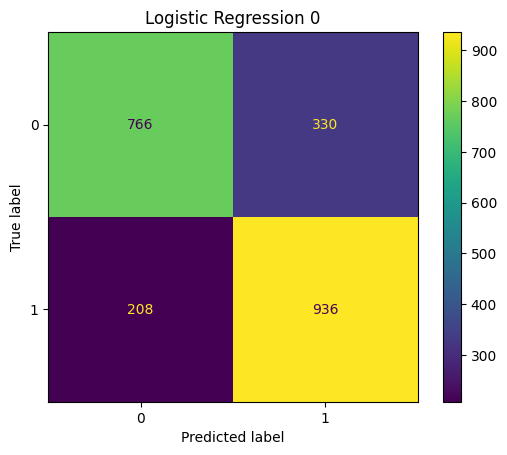

1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7625
[[778 318]
 [214 930]]


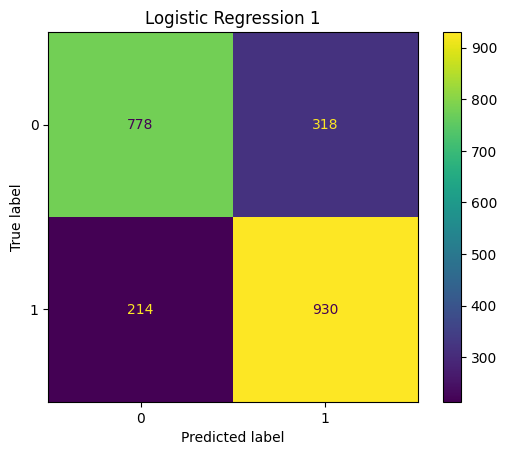

2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7611607142857143
[[778 318]
 [217 927]]


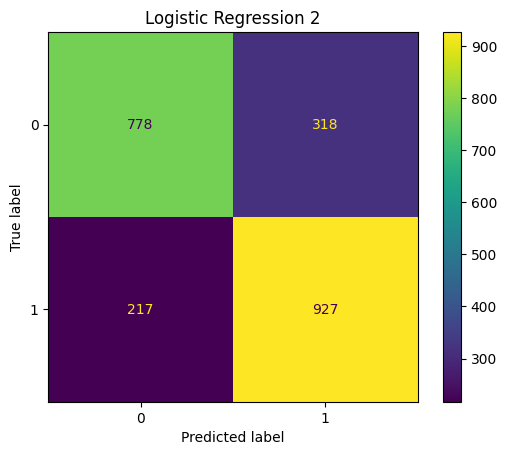

3


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7620535714285714
[[757 339]
 [194 950]]


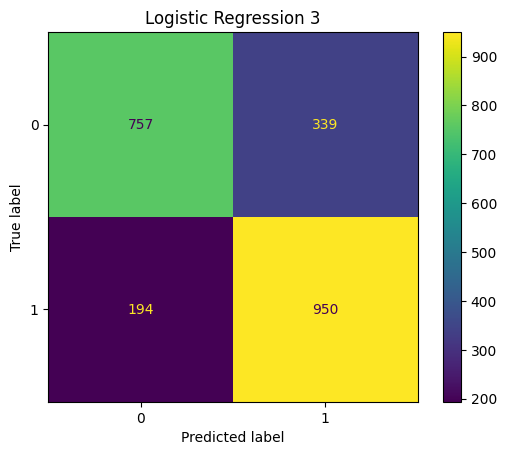

4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.765625
[[773 323]
 [202 942]]


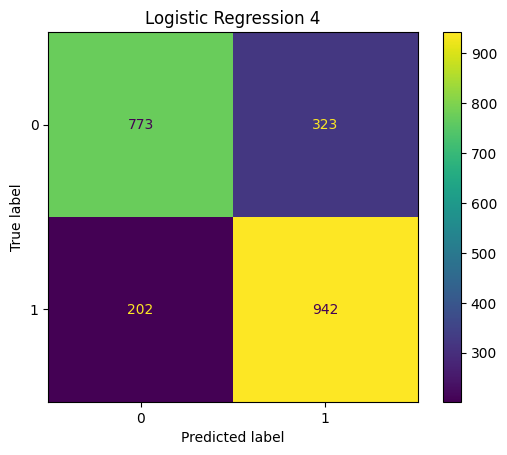

5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7598214285714285
[[771 325]
 [213 931]]


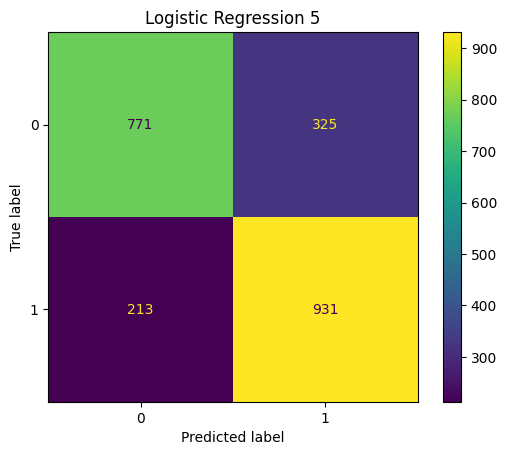

6


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7580357142857143
[[775 321]
 [221 923]]


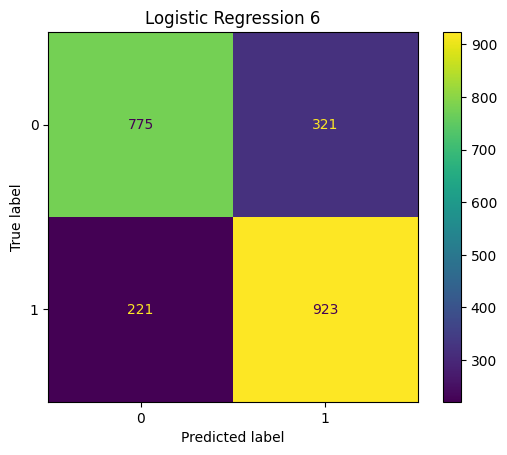

7


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7580357142857143
[[783 313]
 [229 915]]


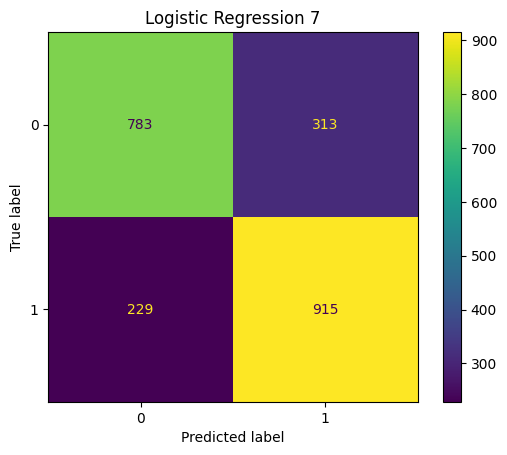

8


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7625
[[783 313]
 [219 925]]


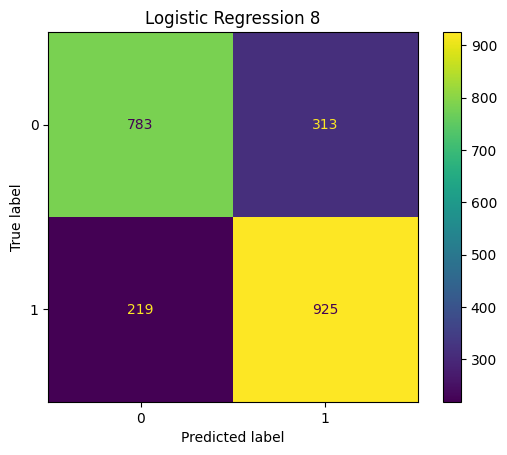

9


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7616071428571428
[[776 320]
 [214 930]]


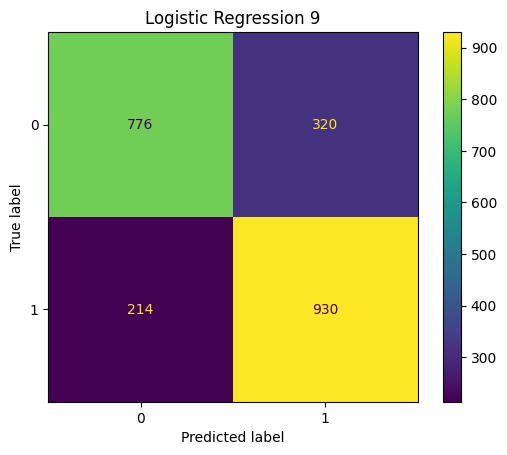

[0.7598214285714285, 0.7625, 0.7611607142857143, 0.7620535714285714, 0.765625, 0.7598214285714285, 0.7580357142857143, 0.7580357142857143, 0.7625, 0.7616071428571428]


In [ ]:
train_logreg_base(split)

random forest
0
0.8348214285714286
[[ 860  236]
 [ 134 1010]]


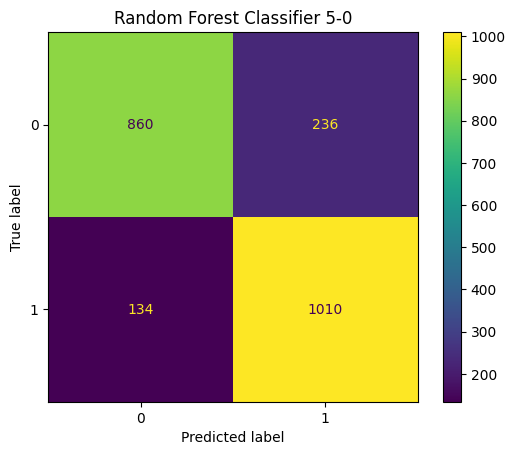

1
0.8357142857142857
[[ 861  235]
 [ 133 1011]]


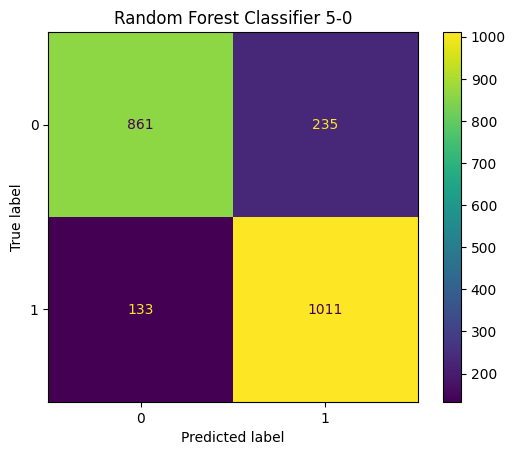

2
0.8325892857142857
[[ 860  236]
 [ 139 1005]]


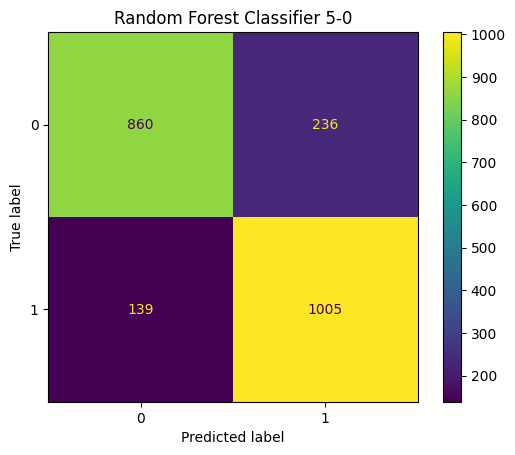

3
0.8352678571428571
[[ 860  236]
 [ 133 1011]]


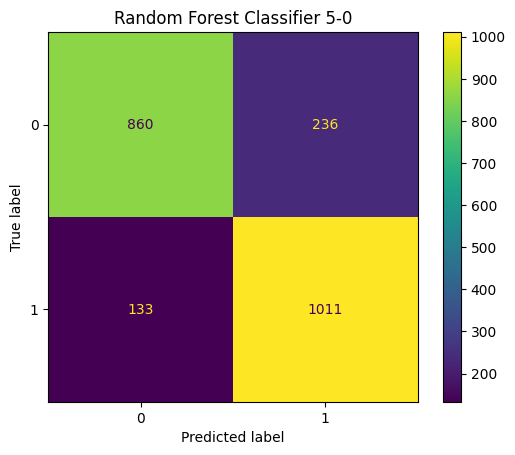

4
0.83125
[[ 857  239]
 [ 139 1005]]


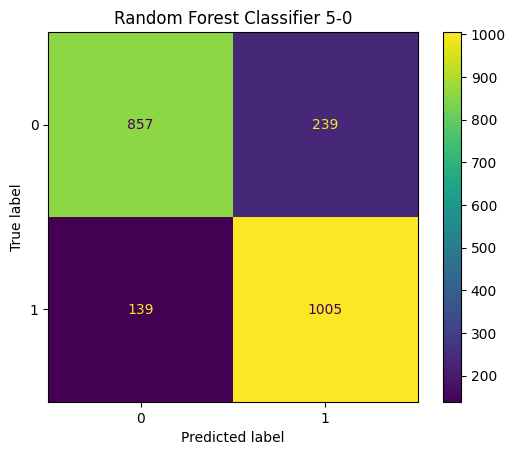

5
0.8294642857142858
[[ 856  240]
 [ 142 1002]]


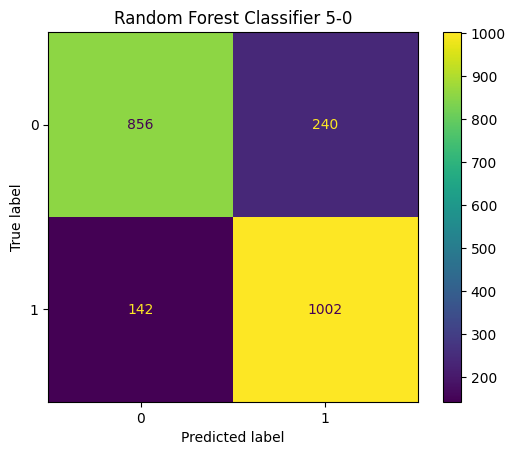

6
0.8321428571428572
[[ 852  244]
 [ 132 1012]]


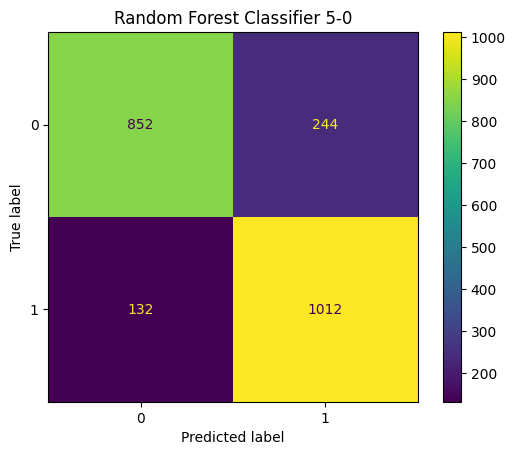

7
0.828125
[[ 853  243]
 [ 142 1002]]


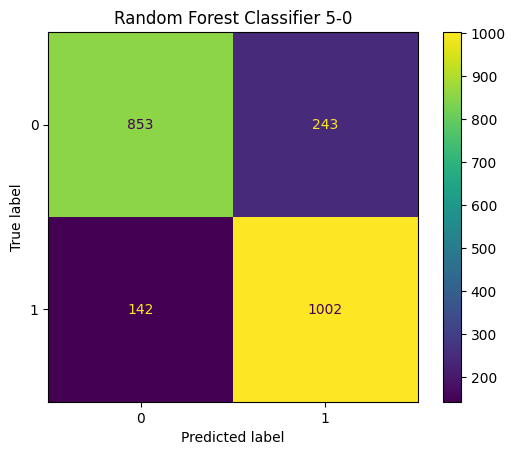

8
0.8330357142857143
[[ 856  240]
 [ 134 1010]]


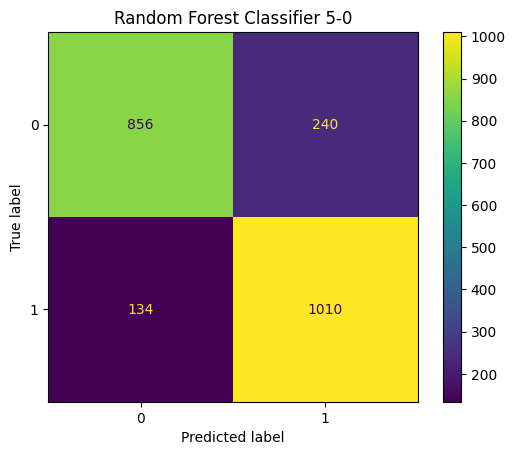

9
0.8357142857142857
[[ 864  232]
 [ 136 1008]]


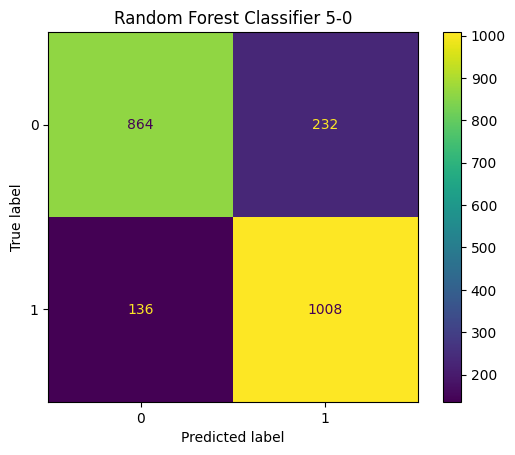

In [ ]:
train_rf_base(split)

0
0.828125
[[ 850  246]
 [ 139 1005]]


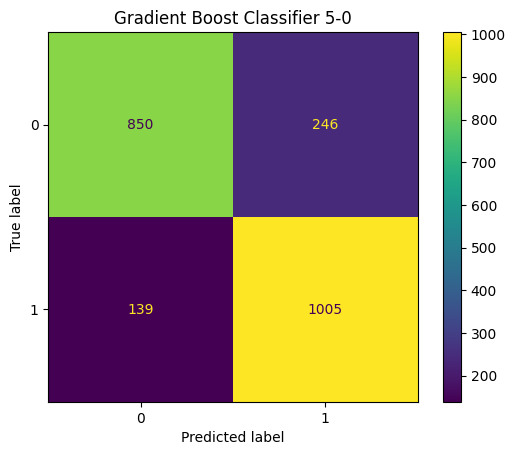

1
0.8303571428571429
[[ 852  244]
 [ 136 1008]]


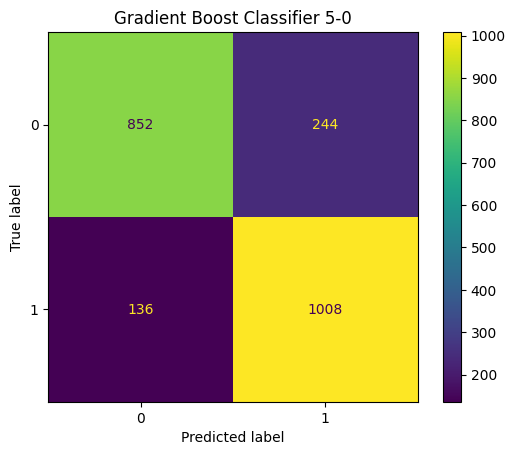

2
0.8267857142857142
[[ 847  249]
 [ 139 1005]]


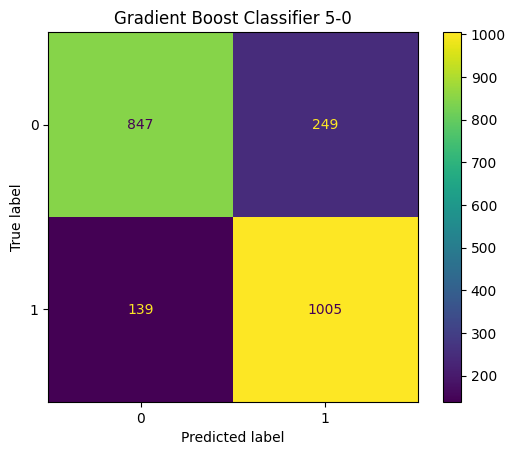

3
0.8263392857142857
[[ 841  255]
 [ 134 1010]]


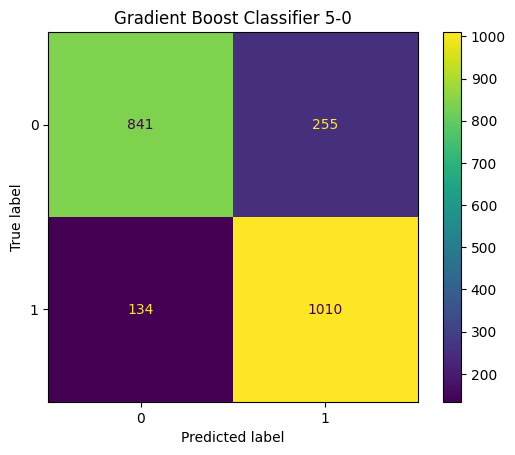

4
0.8308035714285714
[[ 854  242]
 [ 137 1007]]


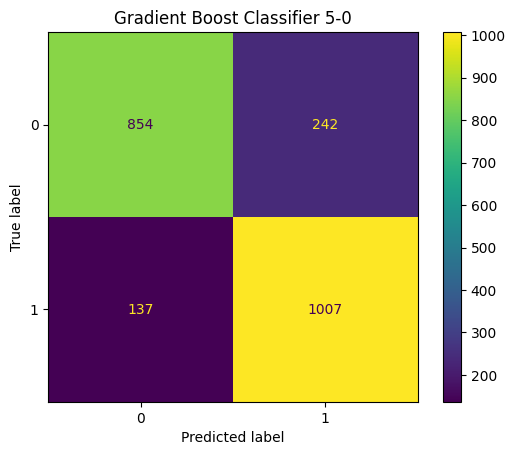

5
0.8339285714285715
[[ 856  240]
 [ 132 1012]]


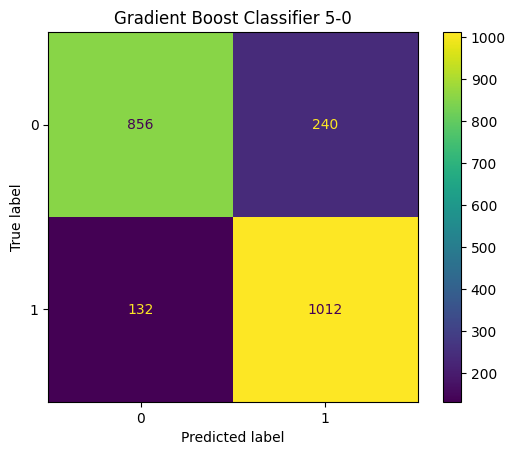

6
0.8276785714285714
[[ 850  246]
 [ 140 1004]]


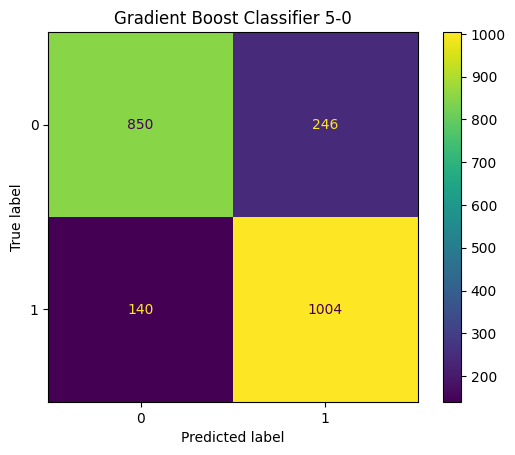

7
0.8290178571428571
[[ 853  243]
 [ 140 1004]]


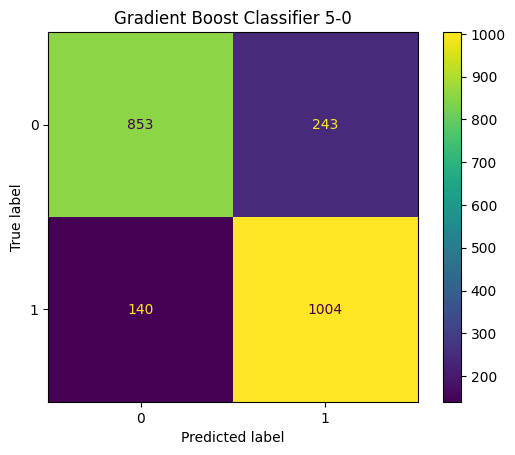

8
0.8308035714285714
[[ 852  244]
 [ 135 1009]]


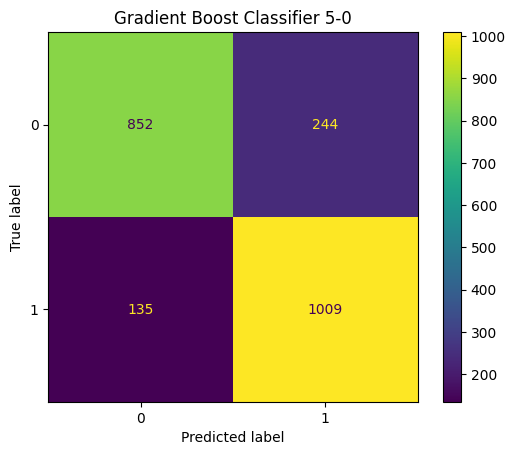

9
0.83125
[[ 852  244]
 [ 134 1010]]


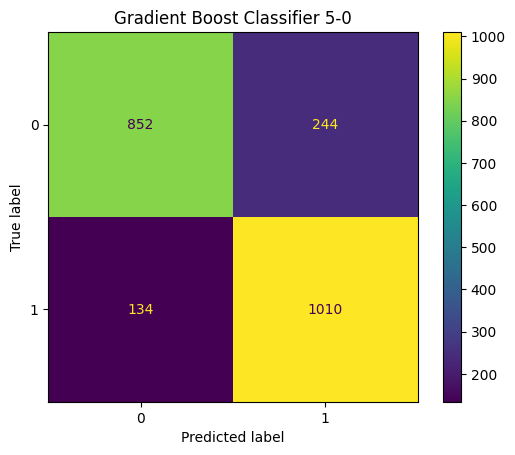

In [ ]:
train_gb_base(split)

### Analysis and Importing Models

In [ ]:
X_train_total, Y_train_total = generateDataSplits(11196 , 11196)
trainX, X_test, trainY, y_test = train_test_split(X_train_total, Y_train_total, test_size=0.1, random_state=0)

In [ ]:
split = "50:50"

In [ ]:
accuracies_gb = np.load(basePath+split+"/gradient_boost_acc.npy")
accuracies_rf = np.load(basePath+split+"/random_forest_acc.npy")
accuracies_lg = np.load(basePath+split+"/logistic_base_acc.npy")

In [ ]:
np.std(accuracies_lg), np.std(accuracies_rf), np.std(accuracies_gb)

(0.002182026680330352, 0.002511532710541997, 0.002227226729154739)

In [ ]:
models_gb = pickle.load(open(basePath+split+"/gradient_boost_base.pkl", 'rb'))
models_rf = pickle.load(open(basePath+split+"/random_forest_base.pkl", 'rb'))
models_lg = pickle.load(open(basePath+split+"/logistic_base.pkl", 'rb'))

In [ ]:
model_gb = models_gb[accuracies_gb.argmax(axis=0)]
model_rf = models_rf[accuracies_rf.argmax(axis=0)]
model_lg = models_lg[accuracies_lg.argmax(axis=0)]
acc_gb, acc_rf, acc_lg = accuracies_gb[accuracies_gb.argmax(axis=0)], accuracies_rf[accuracies_rf.argmax(axis=0)], accuracies_lg[accuracies_lg.argmax(axis=0)]
acc_gb, acc_rf, acc_lg

(0.8339285714285715, 0.8357142857142857, 0.765625)

In [ ]:
np.average(accuracies_gb), np.average(accuracies_rf), np.average(accuracies_lg)

(0.8295089285714285, 0.8328125, 0.7611160714285714)

In [ ]:
model_rf.score(X_test, y_test)

0.8357142857142857

### Model Bias Analysis

In [ ]:
incorrect_trues = []
correct_trues = []
print(len(X_test))

for i in range(len(X_test)):
  result = model_rf.predict([X_test[i]])

  if (result[0] != y_test[i]):
    if (y_test[i] == 1):
      incorrect_trues.append(i)
      print(i)

  if (result[0] == y_test[i]):
    if (y_test[i] == 1):
      correct_trues.append(i)
      print(i)

In [ ]:
len(X_test), len(incorrect_trues), len(correct_trues)

(2240, 136, 1008)

In [ ]:
def getAvgArrayOfIndices(target_indices):
  arraysAvg = []

  for varIdx in range(1, len(variableIndices)):
    newShape = int(math.sqrt(variableIndices[varIdx]-variableIndices[varIdx-1]))
    arraysAvg.append(np.zeros((newShape, newShape)))

  for idx in target_indices:
    for varIdx in range(1, len(variableIndices)):
      newShape = int(math.sqrt(variableIndices[varIdx]-variableIndices[varIdx-1]))
      data = np.array(X_test[idx][variableIndices[varIdx-1]:variableIndices[varIdx]].reshape(newShape, newShape))

      arraysAvg[varIdx-1] = np.add(arraysAvg[varIdx-1], data)

  for i in range(len(arraysAvg)):
    arraysAvg[i] = np.divide(arraysAvg[i], len(target_indices))

  return arraysAvg

In [ ]:
Get standard deviation and max min from each point of missed and not missed

In [ ]:
X_test.shape

(2240, 903)

In [ ]:
arraysAvgTN = getAvgArrayOfIndices(incorrect_trues)
arraysAvgTP = getAvgArrayOfIndices(correct_trues)

2.0
3.0


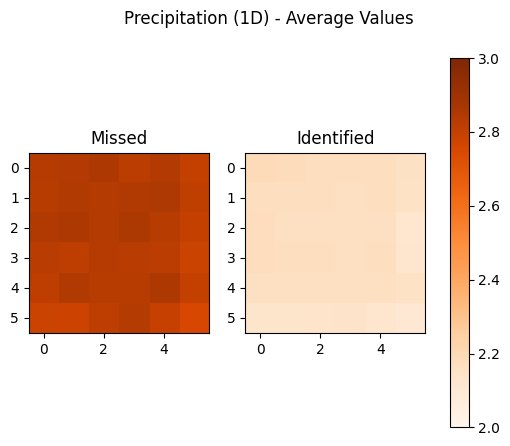

14.0
24.0


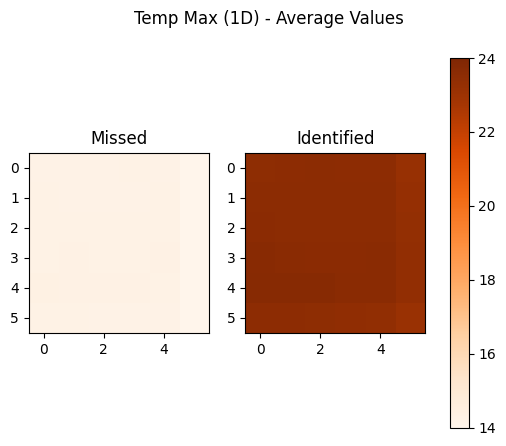

4.0
8.0


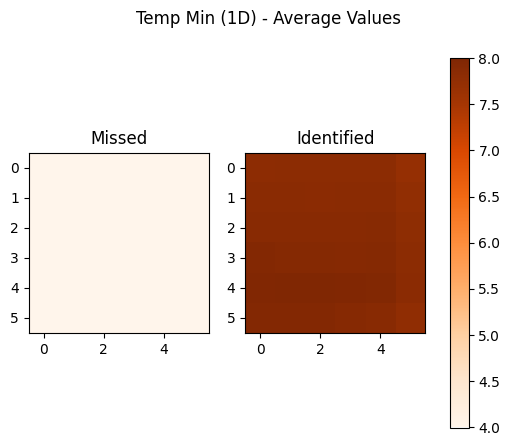

3007.0
3620.0


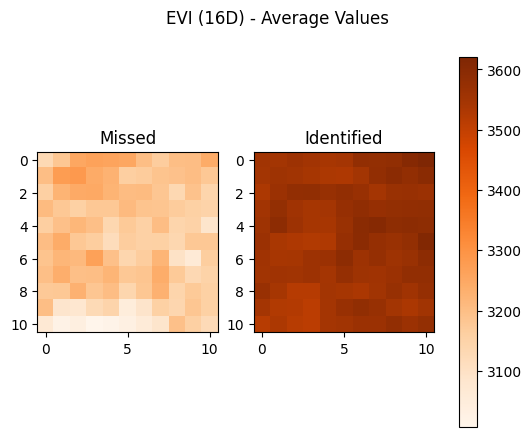

6106.0
6690.0


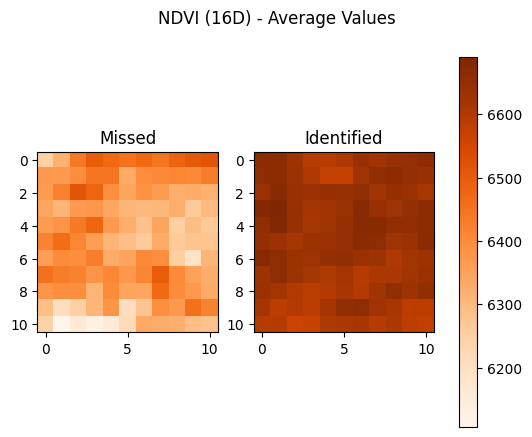

21.0
49.0


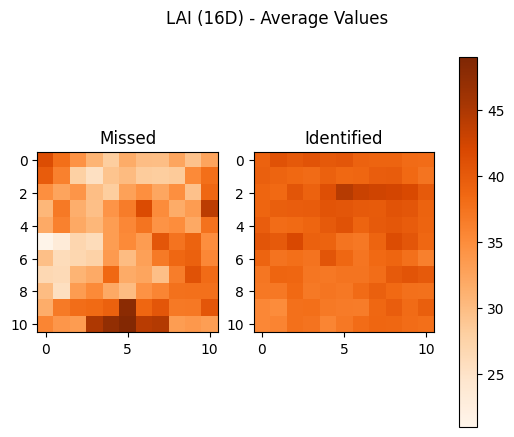

0.0
0.0


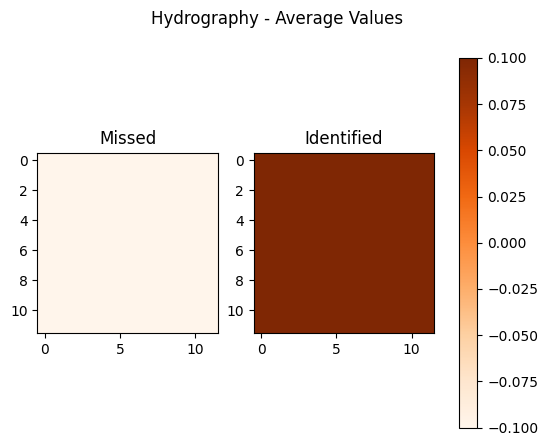

-0.0
0.0


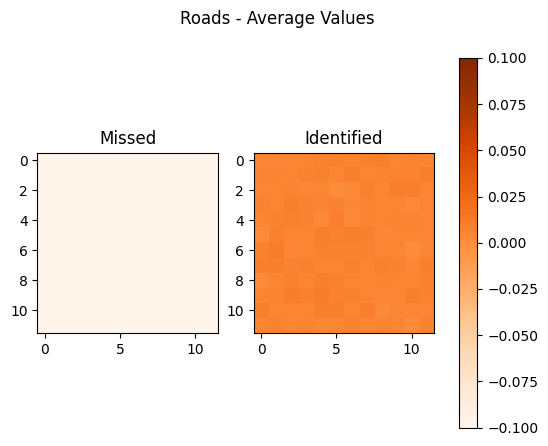

-0.0
0.0


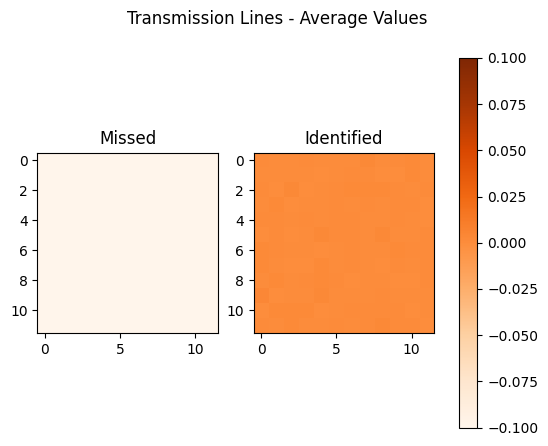

In [ ]:
for varIdx in range(0, len(parameters)):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  maximum = round(max(np.max(arraysAvgTN[varIdx]), np.max(arraysAvgTP[varIdx])), 0)
  minimum = round(min(np.min(arraysAvgTN[varIdx]), np.min(arraysAvgTP[varIdx])), 0)
  print(minimum)
  print(maximum)

  fig.suptitle(parameters[varIdx] + " - Average Values")
  ax1.set_title("Missed")
  ax1.imshow(arraysAvgTN[varIdx], vmin=minimum, vmax=maximum, cmap="Oranges")
  ax2.set_title("Identified")
  im = ax2.imshow(arraysAvgTP[varIdx], vmin=minimum, vmax=maximum, cmap="Oranges")
  fig.colorbar(im, ax=(ax1, ax2), orientation='vertical')
  plt.show()

  # plt.title(parameters[varIdx])
  # plt.imshow(arraysAvgTN[varIdx])
  # plt.colorbar()
  # plt.show()

  # plt.title(parameters[varIdx])
  # plt.imshow(arraysAvgTP[varIdx])
  # plt.colorbar()
  # plt.show()

In [ ]:
print(len(incorrect_trues))

136


In [ ]:
np.save("drive/MyDrive/trainX_demo", X_test)
np.save("drive/MyDrive/trainY_demo", y_test)
pred = model_rf.predict(X_test)
np.save("drive/MyDrive/pred_demo", pred)

In [ ]:
axis = [0, 1]
font = {'size' : 20}

plt.rc('font', **font)

### ROC AUC Curve

In [ ]:
def plot_roc_curve(true_y, y_prob, title, color):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr, color=color)
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

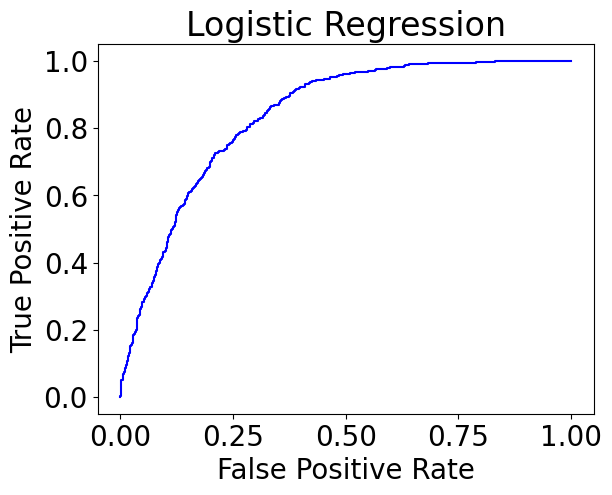

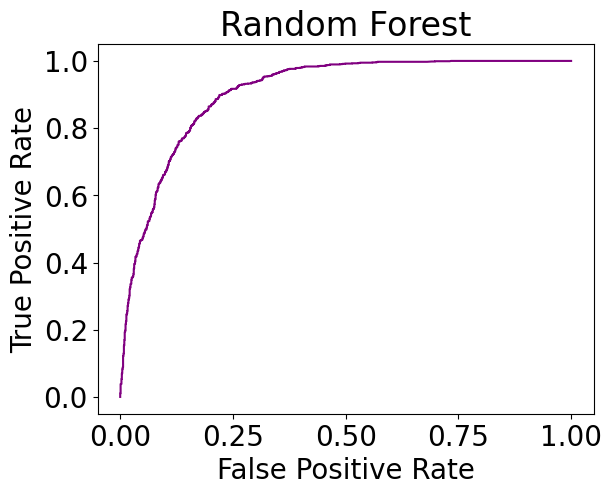

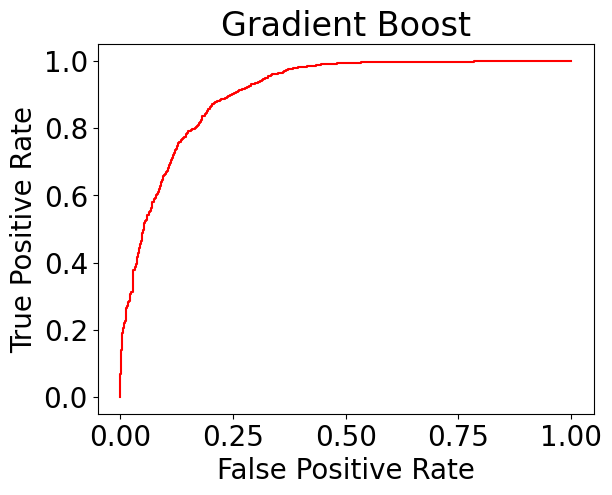

In [ ]:
plot_roc_curve(y_test, model_lg.predict_proba(X_test)[:, 1], "Logistic Regression", "Blue")
plot_roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1], "Random Forest", "Purple")
plot_roc_curve(y_test, model_gb.predict_proba(X_test)[:, 1], "Gradient Boost", "Red")

[[0.7080292  0.2919708 ]
 [0.18706294 0.81293706]]
Logistic Regression - Temporal
[[0.78832117 0.21167883]
 [0.11888112 0.88111888]]
Random Forest Classifier - Temporal
[[0.77737226 0.22262774]
 [0.11713287 0.88286713]]
Gradient Boost Classifier - Temporal


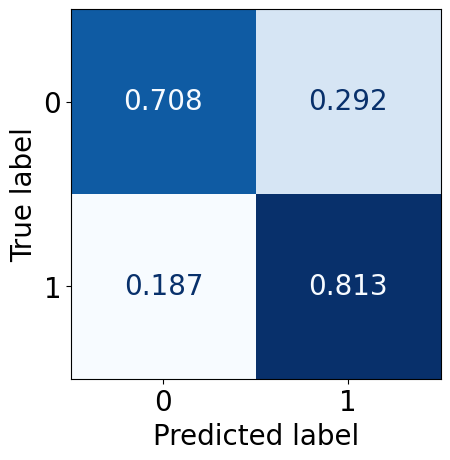

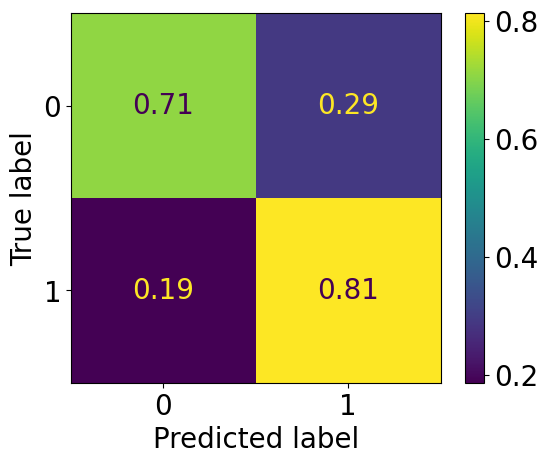

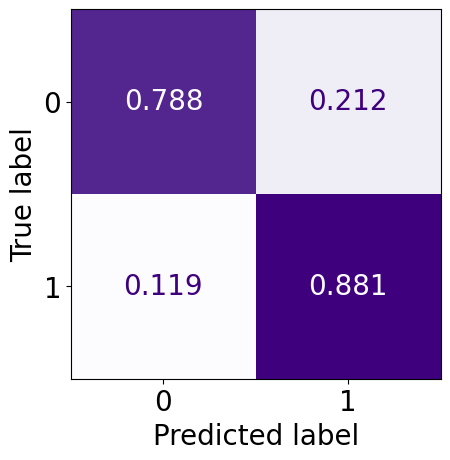

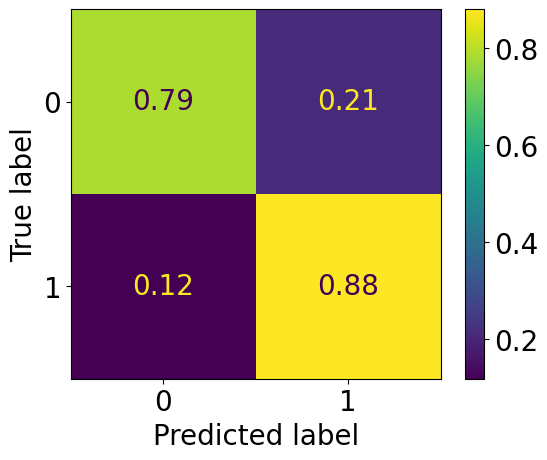

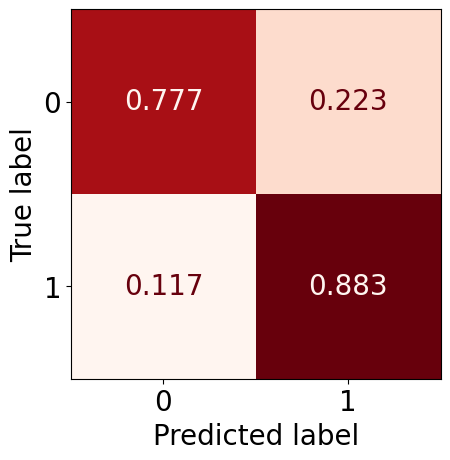

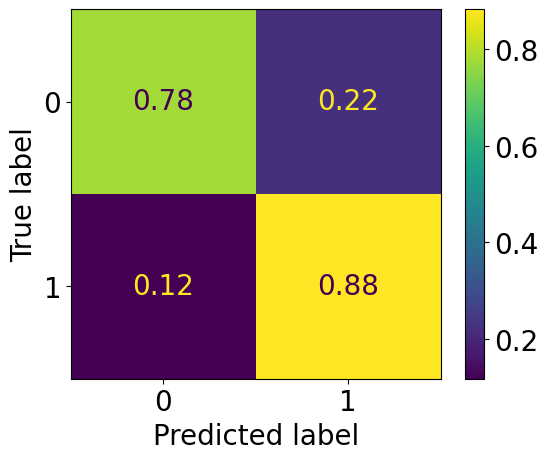

In [ ]:
print(confusion_matrix(y_test, model_lg.predict(X_test), normalize="true"))
print("Logistic Regression - Temporal")
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, y_pred=model_lg.predict(X_test), normalize="true",
    display_labels=model_lg.classes_,
    colorbar=False, cmap="Blues", values_format=".3g"
  ).plot()

print(confusion_matrix(y_test, model_rf.predict(X_test), normalize="true"))
print("Random Forest Classifier - Temporal")
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, y_pred=model_rf.predict(X_test), normalize="true",
    display_labels=model_rf.classes_,
    colorbar=False, cmap="Purples", values_format=".3g"
  ).plot()

print(confusion_matrix(y_test, model_gb.predict(X_test), normalize="true"))
print("Gradient Boost Classifier - Temporal")
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, y_pred=model_gb.predict(X_test), normalize="true",
    display_labels=model_rf.classes_,
    colorbar=False, cmap="Reds", values_format=".3g"
  ).plot()

# ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, model_gb.predict(X_test), normalize="pred"), display_labels=model_gb.classes_).plot()
# plt.title(f"Gradient Boost Classifier - Temporal")
# plt.show()

### Mean Accuracy Decrease

In [ ]:
X_train_total, Y_train_total = generateDataSplits(11196 , 11196)
trainX, X_test, trainY, y_test = train_test_split(X_train_total, Y_train_total, test_size=0.1, random_state=0)

Precipitation (1D)
2240
Logistic
0.7522321428571429
0.013392857142857095
[[772 324]
 [231 913]]


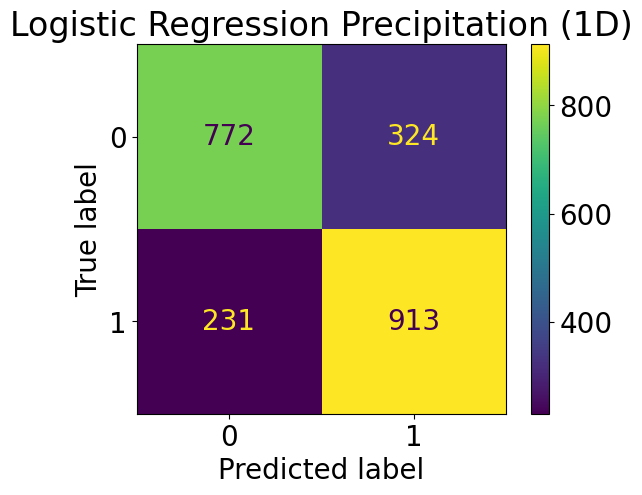

Random Forest
0.8191964285714286
0.01651785714285714
[[846 250]
 [155 989]]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
differences_lg = []
differences_rf = []
differences_gb = []

for i in range(len(variableIndices)-1):
  print(parameters[i])

  mad_test_X, mad_test_y = mixVariable(i+1, X_test , y_test)

  InitialAccuracies = [acc_lg, acc_rf, acc_gb]
  NewAccuracy = []

  print("Logistic")
  lg_score = model_lg.score(mad_test_X, mad_test_y)
  print(lg_score)
  print(acc_lg - lg_score)
  NewAccuracy.append(lg_score)
  differences_lg.append(acc_lg - lg_score)
  # Display
  print(confusion_matrix(mad_test_y, model_lg.predict(mad_test_X)))
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(mad_test_y, model_lg.predict(mad_test_X)), display_labels=model_lg.classes_).plot()
  plt.title(f"Logistic Regression {parameters[i]}")
  plt.show()

  print("Random Forest")
  rf_score = model_rf.score(mad_test_X, mad_test_y)
  print(rf_score)
  print(acc_rf - rf_score)
  NewAccuracy.append(rf_score)
  differences_rf.append(acc_rf - rf_score)
  # Display
  print(confusion_matrix(mad_test_y, model_rf.predict(mad_test_X)))
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(mad_test_y, model_rf.predict(mad_test_X)), display_labels=model_rf.classes_).plot()
  plt.title(f"Random Forest Classifier {parameters[i]}")
  plt.show()

  print("Gradient Boost")
  gb_score = model_gb.score(mad_test_X, mad_test_y)
  print(gb_score)
  print(acc_gb - gb_score)
  NewAccuracy.append(gb_score)
  differences_gb.append(acc_gb - gb_score)
  # Display
  print(confusion_matrix(y_test, model_gb.predict(mad_test_X)))
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(mad_test_y, model_gb.predict(mad_test_X)), display_labels=model_gb.classes_).plot()
  plt.title(f"Gradient Boost Classifier {parameters[i]}")
  plt.show()


  barWidth = 0.25
  fig = plt.subplots()

  br1 = np.arange(len(InitialAccuracies))
  br2 = [x + barWidth for x in br1]
  plt.bar(br1, InitialAccuracies, width=barWidth, label='Initial')
  plt.bar(br2, NewAccuracy, width=barWidth, label="New")
  plt.show()

  print("-"*20)

fig = plt.subplots()
br1 = np.arange(len(differences_lg))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, differences_lg, width=barWidth, label='Logistic')
plt.bar(br2, differences_rf, width=barWidth, label="Random Forest")
plt.bar(br3, differences_gb, width=barWidth, label="Gradient Boost")
plt.xticks([r + barWidth for r in range(len(differences_lg))], parameters)
plt.legend()
plt.show()

barWidth = 0.25
br1 = np.arange(len(differences_lg))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
fig, ax = plt.subplots()

plt.barh(br1, differences_lg, barWidth, label='Logistic', color="royalblue")
plt.barh(br2, differences_rf, barWidth, label="Random Forest", color="blueviolet")
plt.barh(br3, differences_gb, barWidth, label="Gradient Boost", color="orangered")
plt.yticks([r + barWidth for r in range(len(differences_lg))], parameters)
# plt.legend()
plt.show()

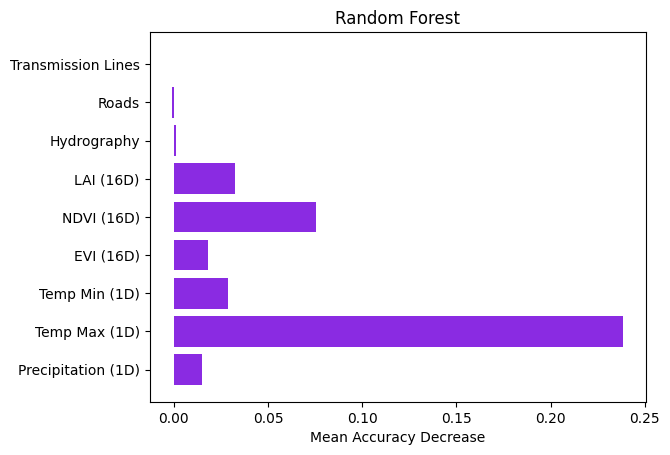

In [ ]:
fig, ax = plt.subplots()
y_pos = np.arange(len(parameters))
ax.barh(y_pos, differences_rf, align='center', color="blueviolet")
ax.set_yticks(y_pos, labels=parameters)
ax.set_xlabel(f"Mean Accuracy Decrease")
ax.set_title(f"Random Forest")
plt.show()

# plt.bar(y_pos, differences_lg, align='center', alpha=0.5)

In [ ]:
print(differences_lg)
print(differences_rf)
print(differences_gb)

[0.01473214285714286, 0.27901785714285715, 0.058482142857142816, 0.010714285714285676, 0.023660714285714257, 0.016071428571428625, 0.004464285714285698, 0.004017857142857184, 0.004017857142857184]
[0.011160714285714302, 0.23482142857142863, 0.024107142857142883, 0.022321428571428603, 0.0669642857142857, 0.025446428571428648, 0.0022321428571429047, -0.0008928571428571397, 0.0]
[0.008928571428571508, 0.28258928571428577, 0.011160714285714302, 0.014285714285714346, 0.05223214285714284, 0.024107142857142883, 0.01383928571428572, 0.002678571428571419, 0.002678571428571419]
